In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from nn_tools.model_builder import Network
from nn_tools.extra_layers import Add, Identity
from pprint import pprint
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

MODEL_SEED = 2824180  # chosen by keyboard-mashing
DATA_SEED = MODEL_SEED + 10

data = tv.datasets.CIFAR10('data/cifar10',
                           train=True,
                           transform=tv.transforms.ToTensor())
loader = torch.utils.data.DataLoader(data,
                                     batch_size=128,
                                     shuffle=True,
                                     generator=torch.Generator().manual_seed(DATA_SEED),
                                     pin_memory=True,
                                     num_workers=16)

# Get a single example batch for testing
im, la = next(iter(loader))

## Define a resnet the old-fashioned way

In [3]:
def validate_layer_size(layer, in_size):
    return layer(torch.randn((1,) + in_size)).size()[1:]


def prod(vals):
    out = 1
    for v in vals:
        out *= v
    return out


class ResBlock(nn.Module):
    """Residual block, inspired by res_block in https://github.com/davidcpage/cifar10-fast/
    """
    def __init__(self, c_in: int, c_out: int, stride: int):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(c_in)
        self.relu1 = nn.ReLU(True)
        self.conv1 = nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(c_out)
        self.relu2 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False)

        if (stride != 1) or (c_out != c_in):
            self.proj = nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False)
        else:
            self.proj = lambda x: x

    def forward(self, x):
        # Preprocess with relu(batchnorm(x))
        x = self.relu1(self.bn1(x))
        # Compute the branch
        branch = self.conv2(self.relu2(self.bn2(self.conv1(x))))
        # Add branch to (maybe) projected input
        return self.proj(x) + branch


class MyResNet(nn.Module):

    def __init__(self, channels=(64, 128, 256, 256)):
        super(MyResNet, self).__init__()
        # Sizes: (3, 32, 32) --> (channels[0], 32, 32)
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels[0])
        self.relu1 = nn.ReLU(True)
        sz = validate_layer_size(self.conv1, (3, 32, 32))


        # Sizes: (64, 32, 32) --> (64, 32, 32)
        self.layer1 = nn.Sequential(
            ResBlock(channels[0], channels[0], 1),
            ResBlock(channels[0], channels[0], 1)
        )
        sz = validate_layer_size(self.layer1, sz)

        # Sizes: (64, 32, 32) --> (128, 16, 16)
        self.layer2 = nn.Sequential(
            ResBlock(channels[0], channels[1], 2),
            ResBlock(channels[1], channels[1], 1)
        )
        sz = validate_layer_size(self.layer2, sz)

        # Sizes: (128, 16, 16) --> (256, 8, 8)
        self.layer3 = nn.Sequential(
            ResBlock(channels[1], channels[2], 2),
            ResBlock(channels[2], channels[2], 1)
        )
        sz = validate_layer_size(self.layer3, sz)

        # Sizes: (256, 8, 8) --> (256, 4, 4)
        self.layer4 = nn.Sequential(
            ResBlock(channels[2], channels[3], 2),
            ResBlock(channels[3], channels[3], 1)
        )
        sz = validate_layer_size(self.layer4, sz)

        # Sizes: (256, 4, 4) --> (256, 1, 1)
        self.pool = nn.MaxPool2d(4)
        sz = validate_layer_size(self.pool, sz)

        # Project to logits
        self.proj = nn.Linear(prod(sz), 10)

    def forward(self, x):
        batches = x.size(0)
        h0 = self.relu1(self.bn1(self.conv1(x)))
        h1 = self.layer1(h0)
        h2 = self.layer2(h1)
        h3 = self.layer3(h2)
        h4 = self.layer4(h3)
        h5 = self.pool(h4)
        return self.proj(h5.view(batches, -1))

Inspect its output

In [4]:
torch.manual_seed(MODEL_SEED)
resnet1 = MyResNet()
out1 = resnet1(im)

print("Output from resnet1 is")
pprint(out1)

Output from resnet1 is
tensor([[ 0.2613, -0.5111, -0.8532,  ...,  0.6979,  0.2353, -0.3902],
        [ 1.6005, -1.0349, -0.4334,  ..., -0.1949,  0.6815, -0.6032],
        [ 0.7319, -0.4630, -0.0822,  ..., -0.2395, -0.0067, -0.3610],
        ...,
        [ 1.1804, -0.9924, -0.1164,  ...,  0.3682,  0.3338,  0.5470],
        [ 0.1324, -0.6616, -0.2074,  ...,  0.0112, -0.1201,  0.2362],
        [ 0.5751, -0.7272, -0.4835,  ...,  0.2314,  0.0520,  0.2642]],
       grad_fn=<AddmmBackward0>)


## Define the same convnet using this fancy dict-parsing tool

In [5]:
def res_block(in_channels, out_channels, stride):
    need_proj = (in_channels != out_channels) or (stride != 1)
    return {
        'prep': nn.Sequential(
            nn.BatchNorm2d(in_channels),    
            nn.ReLU()),
        'branch': (nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        ), 'prep'),
        'proj': (nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False)
                 if need_proj else Identity(), 'prep'),
        'add': (Add(), ['proj', 'branch'])
    }

def get_model_def(channels=(64, 128, 256, 256)):
    return {
        'input': None,
        'preprocess': nn.Sequential(
            nn.Conv2d(3, channels[0], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels[0]),
            nn.ReLU()
        ),
        'group1': {
            'block1': res_block(channels[0], channels[0], stride=1),
            'block2': res_block(channels[0], channels[0], stride=1),
        },
        'group2': {
            'block1': res_block(channels[0], channels[1], stride=2),
            'block2': res_block(channels[1], channels[1], stride=1),
        },
        'group3': {
            'block1': res_block(channels[1], channels[2], stride=2),
            'block2': res_block(channels[2], channels[2], stride=1),
        },
        'group4': {
            'block1': res_block(channels[2], channels[3], stride=2),
            'block2': res_block(channels[3], channels[3], stride=1),
        },
        'pool': nn.MaxPool2d(4),
        'proj': nn.Sequential(nn.Flatten(),
                              nn.Linear(channels[3], 10))
    }

Create a model and inspect its output – now a dict of outputs!

In [6]:
torch.manual_seed(MODEL_SEED)
resnet2 = Network(get_model_def())
# out2 = resnet2(im)
out2 = resnet2({'input': im})

print("Output sizes from resnet2 are")
pprint({k: v.size() for k, v in out2.items()})
print("Outputs from resnet2 are")
pprint(out2)

Output sizes from resnet2 are
{'group1/block1/add': torch.Size([128, 64, 32, 32]),
 'group1/block1/branch': torch.Size([128, 64, 32, 32]),
 'group1/block1/prep': torch.Size([128, 64, 32, 32]),
 'group1/block1/proj': torch.Size([128, 64, 32, 32]),
 'group1/block2/add': torch.Size([128, 64, 32, 32]),
 'group1/block2/branch': torch.Size([128, 64, 32, 32]),
 'group1/block2/prep': torch.Size([128, 64, 32, 32]),
 'group1/block2/proj': torch.Size([128, 64, 32, 32]),
 'group2/block1/add': torch.Size([128, 128, 16, 16]),
 'group2/block1/branch': torch.Size([128, 128, 16, 16]),
 'group2/block1/prep': torch.Size([128, 64, 32, 32]),
 'group2/block1/proj': torch.Size([128, 128, 16, 16]),
 'group2/block2/add': torch.Size([128, 128, 16, 16]),
 'group2/block2/branch': torch.Size([128, 128, 16, 16]),
 'group2/block2/prep': torch.Size([128, 128, 16, 16]),
 'group2/block2/proj': torch.Size([128, 128, 16, 16]),
 'group3/block1/add': torch.Size([128, 256, 8, 8]),
 'group3/block1/branch': torch.Size([128, 2

 'group3/block2/add': tensor([[[[ 4.7514e-01,  3.7585e-02, -1.6060e-01,  ..., -1.4957e-01,
           -1.9452e-01, -1.8039e-01],
          [ 2.5076e-01,  1.4930e+00,  1.2179e+00,  ...,  8.2424e-01,
            8.7651e-01,  1.0189e+00],
          [ 6.3144e-01,  1.0695e+00,  8.2276e-01,  ...,  1.0374e+00,
            7.1812e-01,  9.2459e-01],
          ...,
          [ 1.2538e+00,  1.0535e+00,  7.0262e-01,  ...,  3.2227e-01,
            1.5814e-01,  8.1929e-01],
          [ 8.6887e-01,  8.8768e-01,  5.4049e-03,  ...,  2.2946e-01,
           -6.1941e-01,  3.9346e-02],
          [ 9.5398e-01,  1.6392e+00,  1.2284e+00,  ...,  7.6705e-01,
            9.3297e-01,  8.2626e-01]],

         [[ 3.7593e-01,  5.8050e-01,  7.4632e-01,  ...,  1.8034e-01,
            5.9871e-02,  7.4476e-01],
          [-1.5786e-01, -1.7057e-01,  2.7866e-01,  ..., -2.4236e-01,
            2.5626e-01, -2.7556e-02],
          [-2.2079e-01, -1.0632e-01, -2.7296e-01,  ..., -1.4166e-01,
            1.2382e-04,  4.5946e-01]

Are the outputs from resnet1 and resnet2 the same?

False

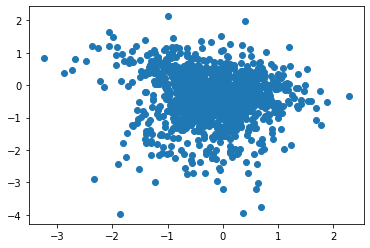

In [7]:
plt.scatter(out1.detach().cpu(), out2['proj'].detach().cpu())
torch.allclose(out1, out2['proj'])

## Cool thing we can now do #1: inspecting hidden unit activity at any point in the network

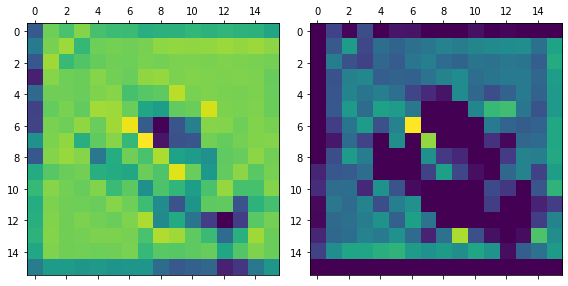

In [8]:
fig, ax = plt.subplots(1,2,figsize=(8,5))
ax[0].matshow(out2['group2/block1/proj'].detach().cpu()[0,0,...])
ax[1].matshow(out2['group2/block2/proj'].detach().cpu()[0,0,...])
fig.tight_layout()

## Cool thing we can now do #2: running the network forward starting at a hidden layer

In [9]:
orig_proj = out2['group2/block2/add'].detach()
jittered_out2 = resnet2({'group2/block2/add': orig_proj + torch.randn(orig_proj.size())*.1}, warn_if_missing=False)

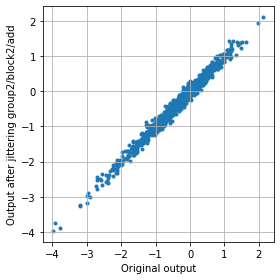

In [10]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.scatter(out2['proj'].detach().cpu(),
           jittered_out2['proj'].detach().cpu(),
           marker='.')
ax.set_xlabel('Original output')
ax.set_ylabel('Output after jittering group2/block2/add')
ax.grid('on')
fig.tight_layout()